In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv('XGB_LGB_Titanic_train.csv')
test = pd.read_csv( 'XGB_LGB_Titanic_test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.isna().sum().sort_values()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64

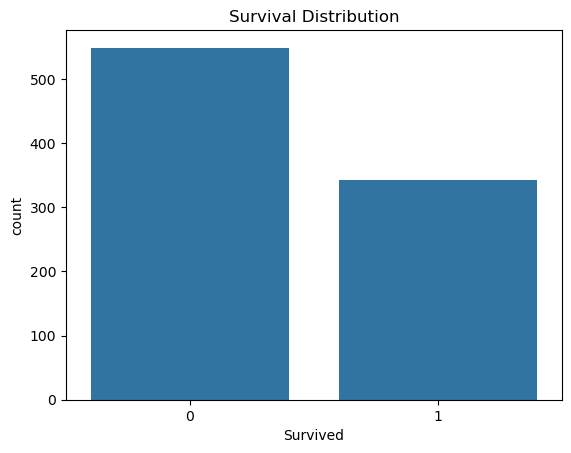

In [6]:
sns.countplot(x='Survived', data=train)
plt.title('Survival Distribution')
plt.show()

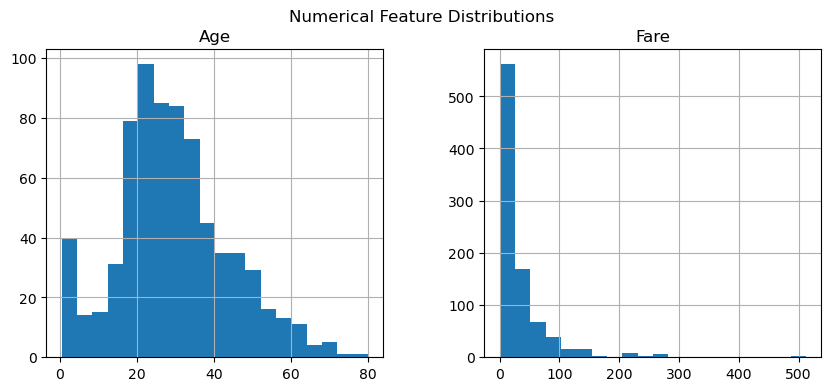

In [7]:
num_cols = ['Age', 'Fare']
train[num_cols].hist(bins=20, figsize=(10,4))
plt.suptitle('Numerical Feature Distributions')
plt.show()

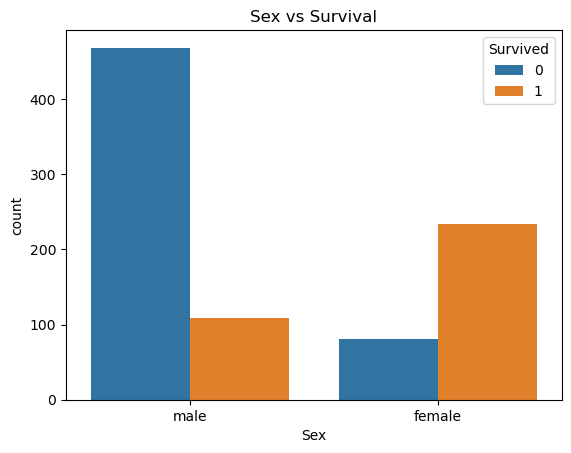

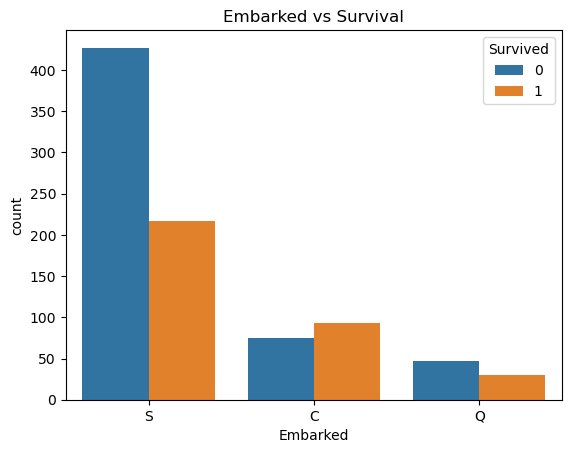

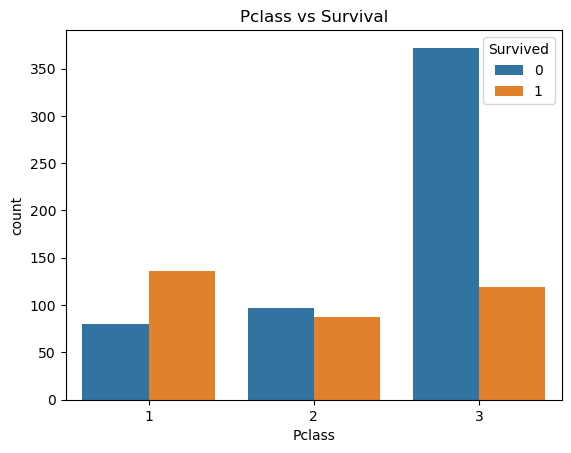

In [8]:
cat_cols = ['Sex', 'Embarked', 'Pclass']
for c in cat_cols:
    sns.countplot(x=c, hue='Survived', data=train)
    plt.title(f'{c} vs Survival')
    plt.show()

In [9]:
drop_cols = ['Cabin', 'Ticket', 'Name']
target = 'Survived'

X = train.drop(columns=drop_cols + [target], errors='ignore')
y = train[target]

X_test = test.drop(columns=drop_cols, errors='ignore')

In [10]:
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features, cat_features

(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Sex', 'Embarked'])

In [11]:
num_pipe = Pipeline([('imp', SimpleImputer(strategy='median'))])

cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocess = ColumnTransformer([('num', num_pipe, num_features),('cat', cat_pipe, cat_features)])

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
lgbm = LGBMClassifier(n_estimators=300,learning_rate=0.05,max_depth=-1,random_state=42)

lgbm_pipe = Pipeline([('prep', preprocess),('clf', lgbm)])

lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('clf',
                 LGBMClassifier(learning_rate=0.05, n_estimators=300,
                                random_state=42))])

In [14]:
xgb = XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,eval_metric='logloss',random_state=42)

xgb_pipe = Pipeline([('prep', preprocess),('clf', xgb)])

xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('clf',
                 XGBClassif...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [15]:
def eval_model(name, model, Xv, yv):
    yp = model.predict(Xv)
    return {
        'Model': name,
        'Accuracy': accuracy_score(yv, yp),
        'Precision': precision_score(yv, yp),
        'Recall': recall_score(yv, yp),
        'F1': f1_score(yv, yp)
    }

results = []
results.append(eval_model('LightGBM', lgbm_pipe, X_val, y_val))
results.append(eval_model('XGBoost', xgb_pipe, X_val, y_val))

pd.DataFrame(results)

C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1
0,LightGBM,0.754190,0.692308,0.652174,0.671642
1,XGBoost,0.765363,0.714286,0.652174,0.681818


C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


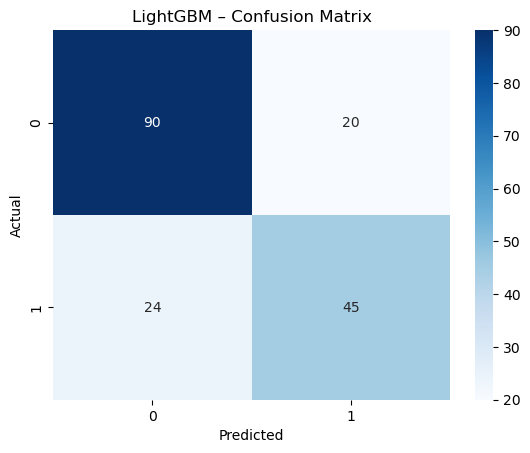

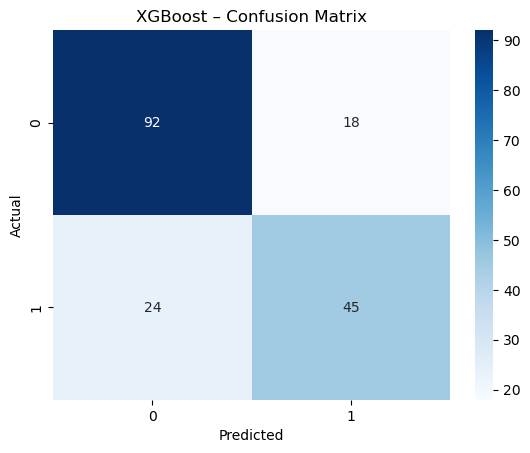

In [16]:
for name, model in [('LightGBM', lgbm_pipe), ('XGBoost', xgb_pipe)]:
    yp = model.predict(X_val)
    cm = confusion_matrix(y_val, yp)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} – Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'acc':'accuracy', 'f1':'f1'}

cv_lgbm = cross_validate(lgbm_pipe, X, y, cv=cv, scoring=scoring)
cv_xgb = cross_validate(xgb_pipe, X, y, cv=cv, scoring=scoring)

pd.DataFrame({
'LGBM_Acc': cv_lgbm['test_acc'],
'XGB_Acc' : cv_xgb['test_acc'],
'LGBM_F1' : cv_lgbm['test_f1'],
'XGB_F1' : cv_xgb['test_f1'],
})

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,LGBM_Acc,XGB_Acc,LGBM_F1,XGB_F1
0,0.860335,0.860335,0.809160,0.809160
1,0.814607,0.803371,0.759124,0.736842
2,0.758427,0.786517,0.671756,0.698413
3,0.803371,0.808989,0.732824,0.742424
4,0.820225,0.853933,0.753846,0.796875


In [18]:
# Choose best model (LightGBM)
best_model = lgbm_pipe

best_model.fit(X, y)
test_pred = best_model.predict(X_test)


submission = pd.DataFrame({'PassengerId': test['PassengerId'],'Survived': test_pred})

submission.head()

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


C:\Users\KAPIL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
